#Part 4 Fine-tuning for arithmetic sentiment analysis

Acknowledgement: We used most of the code from https://mccormickml.com/2019/07/22/BERT-fine-tuning/ 

Most Credit to: 
Chris McCormick and Nick Ryan

# Background

# 1. Setup

## Install transformers repo that has Bert and GPT

In [1]:
!pip install transformers

     |████████████████████████████████| 2.0MB 7.7MB/s 
     |████████████████████████████████| 890kB 49.4MB/s 
     |████████████████████████████████| 3.2MB 53.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=3862cf1350da0351357255b80cd07197ae12fc925edc6cfc0a0d2e84a5d68eb3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Set random seed

In [2]:
import random
import numpy as np
import torch

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Download & Extract
Run the following cells to downlaod the dataset files from the CSC413 webpage.

<!-- Download the two csv dataset files from CSC413 webpage, click the folder icon,  -->
<!-- and click "upload" to upload them.  -->

<!-- https://csc413-2020.github.io/assets/misc/PA03_data_20_train.csv 

https://csc413-2020.github.io/assets/misc/PA03_data_20_test.csv   -->

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=617c5042e2307781bb60fdbc09d377ff7654711f358cfb195335759e8ac76238
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
import wget
import os

print('Downloading verbal arithmetic dataset')

# The URL for the dataset zip file.
url = 'https://csc413-uoft.github.io/2021/assets/misc/'

# Download the file (if we haven't already)
if not os.path.exists('./PA03_data_20_train.csv'):
  wget.download(url + 'PA03_data_20_train.csv', './PA03_data_20_train.csv')
  print('Done downloading training data')
else:
  print('Already downloaded training data')

if not os.path.exists('./PA03_data_20_test.csv'):
  wget.download(url + 'PA03_data_20_test.csv', './PA03_data_20_test.csv')
  print('Done downloading test data')
else:
  print('Already downloaded test data')

Done downloading training data
Done downloading test data


##  Load Training Data

In [5]:
import pandas as pd

df = pd.read_csv("./PA03_data_20_train.csv", header=0, names=["index", "input", "label"])

print("Number of data points: ", df.shape[0])
sampled = df.sample(10)
# Display 10 random rows from the data.
df.sample(10)

Number of data points:  640


,index,input,label
20,264,thirteen plus four,2
180,712,fifteen minus twelve,2
270,327,sixteen plus seven,2
221,58,two plus eighteen,2
542,646,twelve minus six,2
143,626,eleven minus six,2
247,759,seventeen minus nineteen,0
467,691,fourteen minus eleven,2
283,372,eighteen plus twelve,2
259,274,thirteen plus fourteen,2


## Bert Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.


In [6]:
# try bert tokenizer
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
inputs = df.input.values
labels = df.label.values
print("Train data size ", len(inputs))
print(' Original: ', inputs[0])
# Print the sentence split into tokens.
print('Tokenized: ', bert_tokenizer.tokenize(inputs[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(inputs[0])))

Train data size  640
 Original:  five minus twelve
Tokenized:  ['five', 'minus', 'twelve']
Token IDs:  [2274, 15718, 4376]


We can actually use the `tokenizer.__call__` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

## BERT Required Formatting

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".


### Special Tokens

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

On the output of the final transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

### Sentence Length & Attention Mask

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. 

The "Attention Mask" is simply an array of 0s and 1s indicating which tokens are padding and which aren't 

## Sentences to IDs

The `tokenizer.__call__` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special tokens including `[CLS]` and `[SEP]` .
3. Map the tokens to their IDs.
4. Handle padding and assign attention mask accordingly.


In our dataset, all sentences have three word tokens. However, we set the max length of sentence to 7 in this example to show what paddings will be in real world applications.

In [8]:
# Set the maximum sequence length.
MAX_LEN = 7

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(bert_tokenizer.pad_token, bert_tokenizer.pad_token_id))


Padding/truncating all sentences to 7 values...

Padding token: "[PAD]", ID: 0


In [9]:
# pytorch version

# `tokenizer.__call__` will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Add paddings.
#   (6) Provide attention masks.
tokenized_inputs = bert_tokenizer(
                    inputs.tolist(),           # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    padding = 'max_length',    # pad to a length specified 
                                               # by the max_length.
                    max_length = MAX_LEN,      # Truncate all sentences.
                    return_tensors = 'pt',     # Return pytorch tensors.
                )

input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']

# Print sentence 0, now as a list of IDs.
print('Original: ', inputs[0])
print('Token IDs:', input_ids[0])
print('Tokenized:', bert_tokenizer.decode(input_ids[0]))
print('Attention_mask', attention_masks[0])

bert_input_ids = input_ids
bert_attention_masks = attention_masks

Original:  five minus twelve
Token IDs: tensor([  101,  2274, 15718,  4376,   102,     0,     0])
Tokenized: [CLS] five minus twelve [SEP] [PAD] [PAD]
Attention_mask tensor([1, 1, 1, 1, 1, 0, 0])


## GPT Tokenizer

Similar to the BERT Tokenizer, but we have to explicitly add the padding token.

In [10]:
from transformers import OpenAIGPTTokenizer

print('Loading GPT tokenizer...')
gpt_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt', do_lower_case=True)
special_tokens_dict = {'pad_token': '<PAD>'}
gpt_tokenizer.add_special_tokens(special_tokens_dict)
print('pad_token', gpt_tokenizer.pad_token)

Loading GPT tokenizer...


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.



pad_token <PAD>


## GPT Required Formatting

There is no special token in the pretraining stage of GPT. In fine tuning, although the original paper suggested using "start" and "extract" tokens, here we follow the implementation of HuggingFace that we are going to simply use the representation of the last token in the sentence for later classification. 

Therefore, we only need to add padding tokens.


In [11]:
# pytorch version

# `tokenizer.__call__` will:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start.
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Add paddings.
#   (6) Provide attention masks.
tokenized_inputs = gpt_tokenizer(
                    inputs.tolist(),           # Sentence to encode.
                    padding = 'max_length',    # pad to a length specified 
                                               # by the max_length.
                    max_length = MAX_LEN,      # Truncate all sentences.
                    return_tensors = 'pt',     # Return pytorch tensors.
                )

input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']

# Print sentence 0, now as a list of IDs.
print('Original: ', inputs[0])
print('Token IDs:', input_ids[0])
print('Tokenized:', gpt_tokenizer.decode(input_ids[0]))
print('Attention_mask', attention_masks[0])

gpt_input_ids = input_ids
gpt_attention_masks = attention_masks

Original:  five minus twelve
Token IDs: tensor([ 1643, 16572,  4274, 40478, 40478, 40478, 40478])
Tokenized: five minus twelve <PAD> <PAD> <PAD> <PAD>
Attention_mask tensor([1, 1, 1, 0, 0, 0, 0])


## Training & Validation Split

Divide up our training set to use 80% for training and 20% for validation.

We'also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [12]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

def train_valid_split(input_ids, attention_masks):
  # Use 80% for training and 20% for validation.
  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                              random_state=2021, test_size=0.2)
  # Do the same for the masks.
  train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                              random_state=2021, test_size=0.2)

  set(labels)
  print('example train_input:', train_inputs[0])
  print('example attention_mask', train_masks[0])

  train_labels = torch.tensor(train_labels)
  validation_labels = torch.tensor(validation_labels)

  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set.
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  return train_dataloader, validation_dataloader

In [13]:
bert_train_dataloader, bert_validation_dataloader = train_valid_split(bert_input_ids, bert_attention_masks)

example train_input: tensor([  101,  4376, 15718,  5417,   102,     0,     0])
example attention_mask tensor([1, 1, 1, 1, 1, 0, 0])


In [14]:
gpt_train_dataloader, gpt_validation_dataloader = train_valid_split(gpt_input_ids, gpt_attention_masks)

example train_input: tensor([ 4274, 16572,  3751, 40478, 40478, 40478, 40478])
example attention_mask tensor([1, 1, 1, 0, 0, 0, 0])


# 4. Questions

## Question1 [1pts]

The pre-trained neural network here is the normal BERT model from [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). The goal is to add a new classification layer to the pre-trained model. We have provided two example classes to do so.

In this part, you need to make your own  `GPTCSC413` class `self.classifier` which will build on a pretrained [gpt](https://huggingface.co/openai-gpt) model and add a clsddifier at the end.

In [15]:
from transformers import BertForSequenceClassification
import torch.nn as nn
class BertCSC413_Linear(BertForSequenceClassification):
    def __init__(self, config):
        super(BertCSC413_Linear, self).__init__(config)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

class BertCSC413_MLP(BertForSequenceClassification):
    def __init__(self, config):
        super(BertCSC413_MLP, self).__init__(config)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, self.config.num_labels)
            )

In [16]:
from transformers import OpenAIGPTForSequenceClassification
class GPTCSC413(OpenAIGPTForSequenceClassification):
    def __init__(self, config):
        super(GPTCSC413, self).__init__(config)
        # Your own classifier goes here
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, self.config.num_labels)
            )

## Question2 [0pts]

We instantiated two different BERT models from `BertCSC413_MLP` class, which are called `model_freeze_bert` and `model_finetune_bert` in the notebook. 

**Run** the following code to train the models, and attach the training error curves of `model_freeze_bert` and `model_finetune_bert`.  
    
Comment on how these two models will differ during the training? Which one would lead to smaller training errors? Which one would generalize better? And briefly discuss why models are failing under certain target labels.   

In [17]:
from transformers import AdamW, BertConfig

model_freeze_bert = BertCSC413_MLP.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertCSC413_MLP: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertCSC413_MLP from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCSC413_MLP from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertCSC413_MLP were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0

In [18]:
for name, param in model_freeze_bert.named_parameters():
	if 'classifier' not in name: # classifier layer
		param.requires_grad = False

In [19]:
model_finetune_bert = BertCSC413_Linear.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,    
    output_attentions = False, 
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertCSC413_Linear: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertCSC413_Linear from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertCSC413_Linear from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertCSC413_Linear were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['

In [20]:
# Model parameters visualization
params = list(model_finetune_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

We use
- Batch size: 32
- Learning rate (Adam): 2e-5  
- Number of epochs: 4

In [21]:
from transformers import get_linear_schedule_with_warmup
import time
import datetime

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

def train_model(model, epochs, train_dataloader, validation_dataloader):      
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)
    loss_values = []
    eval_accs = []

    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()

        total_loss = 0
        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0] #.to(device)
            b_input_mask = batch[1] #.to(device)
            b_labels = batch[2] #.to(device)

            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # This will return the loss (rather than the model output) because we
            # have provided the `labels`.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
            
            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
            

        print("Running Validation...")

        t0 = time.time()
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            # batch = tuple(t.to(device) for t in batch)
            batch = tuple(t for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have
                # not provided labels.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask)
            
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits = outputs[0]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            # Track the number of batches
            nb_eval_steps += 1

        avg_eval_acc = eval_accuracy/nb_eval_steps
        print("  Accuracy: {0:.2f}".format(avg_eval_acc))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))
        eval_accs.append(avg_eval_acc)
    print("")
    print("Training complete!")
    return loss_values, eval_accs

In [22]:
freeze_bert_loss_vals, freeze_bert_eval_accs = train_model(model_freeze_bert, 4, 
                                    bert_train_dataloader,
                                    bert_validation_dataloader) # about 1 minute for 4 epochs using CPU


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.97
  Training epcoh took: 0:00:10
Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.79
  Training epcoh took: 0:00:10
Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.72
  Training epcoh took: 0:00:10
Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.70
  Training epcoh took: 0:00:09
Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:02

Training complete!


In [23]:
finetune_bert_loss_vals, finetune_bert_eval_accs = train_model(model_finetune_bert, 4,
                                                               bert_train_dataloader,
                                                               bert_validation_dataloader) # about 5 minutes for 4 epochs using CPU


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.72
  Training epcoh took: 0:00:41
Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.43
  Training epcoh took: 0:00:41
Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.33
  Training epcoh took: 0:00:41
Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:00:41
Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:02

Training complete!


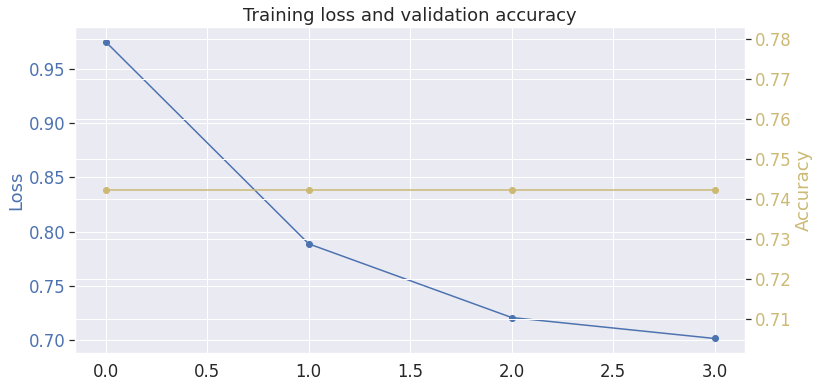

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
def plot_loss_and_acc(loss_vals, eval_accs):
    sns.set(style='darkgrid')
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(loss_vals, 'b-o', label = 'training loss')
    ax2 = ax1.twinx()
    ax2.plot(eval_accs, 'y-o', label = 'validation accuracy')
    ax2.set_title("Training loss and validation accuracy")
    ax2.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='b')
    ax2.set_ylabel("Accuracy", color='y')
    ax1.tick_params(axis='y', rotation=0, labelcolor='b' )
    ax2.tick_params(axis='y', rotation=0, labelcolor='y' )
    plt.show()
plot_loss_and_acc(freeze_bert_loss_vals, freeze_bert_eval_accs)

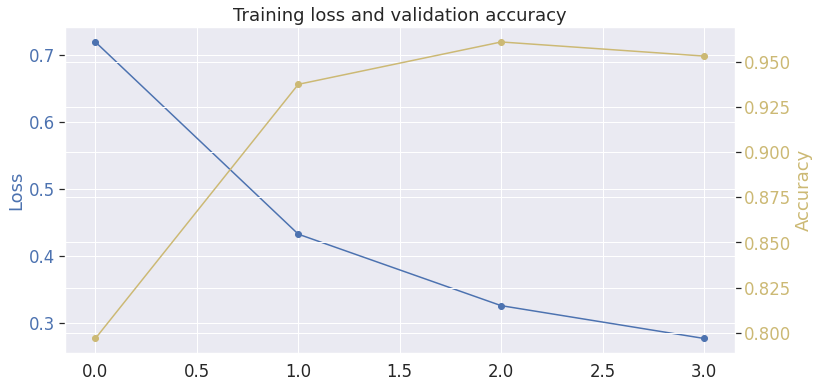

In [25]:
plot_loss_and_acc(finetune_bert_loss_vals, finetune_bert_eval_accs)

*Run* the evaluation functions.  Report the test performances of using trained model\_freeze\_bert and model\_finetune\_bert, and briefly discuss why models are failing under certain target labels

In [26]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./output.txt_test.csv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_csv("./PA03_data_20_test.csv", header=0, names=["index", "input", "label"])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

inputs = df.input.values
labels = df.label.values

def make_test_data(tokenizer):
  tokenized_inputs = tokenizer(
                      inputs.tolist(),                     # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      padding = 'max_length',    # pad to a length specified 
                                                  # by the max_length.
                      max_length = 7,            # Truncate all sentences.
                      return_tensors = 'pt',     # Return pytorch tensors.
                  )

  input_ids = tokenized_inputs['input_ids']
  attention_masks = tokenized_inputs['attention_mask']


  # Convert to tensors.
  prediction_inputs = torch.tensor(input_ids)
  prediction_masks = torch.tensor(attention_masks)
  prediction_labels = torch.tensor(labels)

  # Set the batch size.  
  batch_size = 32  

  # Create the DataLoader.
  prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
  return prediction_dataloader

Number of test sentences: 160



In [27]:
bert_test_dataloader = make_test_data(bert_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [28]:
def eval_testdata(model_test, prediction_dataloader, tokenizer, show_all_predictions=False):
    print('Predicting labels for {:,} test sentences...'.format(len(prediction_dataloader.dataset)))

    # Put model in evaluation mode
    model_test.eval()

    # Tracking variables 
    predictions , true_labels, input_sents = [], [], []

    # Predict 
    for batch in prediction_dataloader:
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        decoded_inputs = [tokenizer.decode(b_input_ids[i]).strip("[CLS] ").strip( "[SEP] ").strip(" [PAD] ").strip("[PAD]").strip(" [SE") for i in range(len(b_input_ids))]
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model_test(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        input_sents.extend(decoded_inputs)
        
        # Store predictions and true labels
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)
    correct = [0,0,0]
    totals = [0, 0, 0]
    for true_label, prediction in zip(true_labels, predictions):
        if true_label == prediction:
            correct[true_label] += 1
        totals[true_label] += 1
    print("Number of expressions with negative result", true_labels.count(0), "\n",  correct[0],  " predicted correctly",  ", accuracy ", correct[0]/totals[0] , "\n")
    print("Number of expressions with 0 result", true_labels.count(1), "\n",  correct[1], " predicted correctly", ", accuracy ", correct[1]/totals[1], "\n")
    print("Number of expressions with positive result", true_labels.count(2),"\n",  correct[2], " predicted correctly",", accuracy ", correct[2]/totals[2], "\n")
    if show_all_predictions:
        index_to_sentiment_map = {0:"negative", 1:"zero", 2:"positive"}
        for sent in [sent + "--> "+index_to_sentiment_map[index]  for sent, index in zip(input_sents, predictions)]:
            print(sent)

In [29]:
eval_testdata(model_freeze_bert, bert_test_dataloader, bert_tokenizer, show_all_predictions=False)

Predicting labels for 160 test sentences...
Number of expressions with negative result 47 
 0  predicted correctly , accuracy  0.0 

Number of expressions with 0 result 2 
 0  predicted correctly , accuracy  0.0 

Number of expressions with positive result 111 
 111  predicted correctly , accuracy  1.0 



In [30]:
eval_testdata(model_finetune_bert, bert_test_dataloader, bert_tokenizer, show_all_predictions=False)

Predicting labels for 160 test sentences...
Number of expressions with negative result 47 
 47  predicted correctly , accuracy  1.0 

Number of expressions with 0 result 2 
 0  predicted correctly , accuracy  0.0 

Number of expressions with positive result 111 
 109  predicted correctly , accuracy  0.9819819819819819 



## Question3 [0pts]

We instantiated a GPT model from `GPTCSC413` class, which is called `model_finetune_gpt`. **Run** the training and evaluation functions for the model.
    
Compare the performance of `model_finetune_bert` and `model_finetune_gpt`. Try a few unseen examples of arithmetic questions using both model, and find 10 interesting results.

In [31]:
model_finetune_gpt = GPTCSC413.from_pretrained(
    "openai-gpt", 
    num_labels = 3,    
    output_attentions = False, 
    output_hidden_states = False,
)
# resize model embedding to match new tokenizer
model_finetune_gpt.resize_token_embeddings(len(gpt_tokenizer))

# fix model padding token id
model_finetune_gpt.config.pad_token_id = gpt_tokenizer.pad_token_id
print('pad token set to: ', model_finetune_gpt.config.pad_token_id)

Some weights of GPTCSC413 were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['classifier.0.bias', 'classifier.2.weight', 'score.weight', 'classifier.2.bias', 'classifier.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


pad token set to:  40478


In [32]:
finttune_gpt_loss_values, finttune_gpt_eval_accs = train_model(model_finetune_gpt, 4, 
                                                               gpt_train_dataloader,
                                                               gpt_validation_dataloader) # about 5 minutes for 4 epochs using CPU


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.50
  Training epcoh took: 0:00:45
Running Validation...
  Accuracy: 0.88
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.28
  Training epcoh took: 0:00:46
Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.20
  Training epcoh took: 0:00:46
Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:03

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:46
Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:03

Training complete!


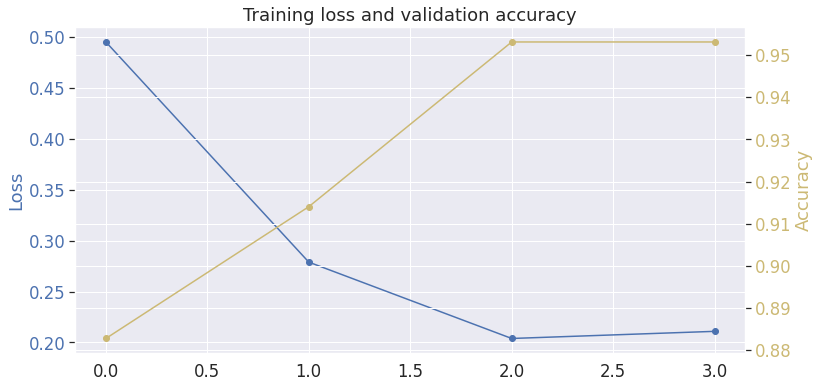

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Predicting labels for 160 test sentences...
Number of expressions with negative result 47 
 44  predicted correctly , accuracy  0.9361702127659575 

Number of expressions with 0 result 2 
 0  predicted correctly , accuracy  0.0 

Number of expressions with positive result 111 
 111  predicted correctly , accuracy  1.0 



In [33]:
plot_loss_and_acc(finttune_gpt_loss_values, finttune_gpt_eval_accs)
gpt_test_dataloader = make_test_data(gpt_tokenizer)
eval_testdata(model_finetune_gpt, gpt_test_dataloader, gpt_tokenizer, show_all_predictions=False)

In [34]:
index_to_sentiment_map = {0:"negative", 1:"zero", 2:"positive"}
def what_is(arithmetic_input, model=model_finetune_gpt):
    if isinstance(model, GPTCSC413):
      tokenizer = gpt_tokenizer
    elif isinstance(model, BertForSequenceClassification):
      tokenizer = bert_tokenizer
    else:
      raise ValueError
    tokenized_inputs = tokenizer(
                        arithmetic_input,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        padding = 'max_length',    # pad to a length specified 
                                                    # by the max_length.
                        max_length = 7,            # Truncate all sentences.
                        return_tensors = 'pt',     # Return pytorch tensors.
                    )

    input_ids = tokenized_inputs['input_ids']
    attention_masks = tokenized_inputs['attention_mask']


    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, 
                            attention_mask=attention_masks)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        print(index_to_sentiment_map[np.argmax(logits, axis=1)[0]])

In [35]:
what_is("three minus two minus two", model=model_finetune_gpt)

positive


In [36]:
what_is("three minus two minus two", model=model_finetune_bert)

negative


In [37]:
what_is("three minus 1", model=model_finetune_bert)

negative


## Question4 [1pts]

Come up with 1 scenario/application that GPT architecture is more preferred than BERT. The proposed scenario/appication is not limited to sentiment classification or Natual Language Processing (NLP).

## Question5 [0pts]

This is an open question, and we will give marks as long as you show an attempt to try one of the following tasks.   
1. Try data augmentation tricks to improve the performances for certain target labels that models were failing to predict.  
2. Make a t-sne or PCA plot to visualize the embedding vectors of word tokens related to arithmetic expressions. 
3. Try different hyperparameter tunings. E.g. learning rates, optimizer, architecture of the classifier, training epochs, and batch size.  
4. Evaluate the Multi-class Matthews correlation score for our imbalanced test dataset.  
5. Run a baseline model using MLP without pre-trained BERT or GPT. You can assume the sequence length of all the data is 3 in this case.